In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

plt.style.use("ggplot")

BASE_DATA_DIR = os.path.abspath("../data")
print("Using base data directory:", BASE_DATA_DIR)

Using base data directory: /work/data


In [2]:
json_files = glob(os.path.join(BASE_DATA_DIR, "**/*.json"), recursive=True)

print("Found JSON files:")
for f in json_files:
    print("  ", f)

print("\nTotal JSON files:", len(json_files))


Found JSON files:
   /work/data/GFTYRV/project-4-at-2025-10-30-12-12-aaf7a367.json
   /work/data/VWXUD6/project-2-at-2025-10-09-14-58-ff8fc43d.json
   /work/data/XOBJYX/labels.json
   /work/data/YH6M5S/YH6M5S_labels.json

Total JSON files: 4


In [3]:
# DATA QUALITY DIAGNOSTIC: Check JSON files for annotation issues
import json
import os
from glob import glob

print("=" * 80)
print("JSON FILE DIAGNOSTIC REPORT")
print("=" * 80)

json_files = glob(os.path.join(BASE_DATA_DIR, "**/*.json"), recursive=True)

for json_path in json_files:
    folder = os.path.dirname(json_path)
    folder_name = os.path.basename(folder)
    
    print(f"\n📁 Folder: {folder_name}")
    print(f"   JSON: {os.path.basename(json_path)}")
    
    try:
        with open(json_path, "r", encoding="utf-8") as f:
            entries = json.load(f)
        
        # Count entries with actual annotations
        entries_with_labels = 0
        total_segments = 0
        missing_csvs = []
        
        for entry in entries:
            file_upload = entry.get("file_upload", "")
            annotations = entry.get("annotations", [])
            
            if annotations and annotations[0].get("result"):
                entries_with_labels += 1
                total_segments += len(annotations[0]["result"])
            
            # Check if CSV exists
            clean_name = file_upload.split("-", 1)[1] if "-" in file_upload else file_upload
            candidates = [
                os.path.join(folder, file_upload),
                os.path.join(folder, clean_name),
            ]
            if not any(os.path.exists(c) for c in candidates):
                missing_csvs.append(file_upload)
        
        print(f"   Total entries: {len(entries)}")
        print(f"   ✅ Entries with labeled segments: {entries_with_labels}")
        print(f"   📊 Total labeled segments: {total_segments}")
        
        if missing_csvs:
            print(f"   ⚠️  Missing CSV files: {len(missing_csvs)}")
            for csv in missing_csvs[:3]:  # Show first 3
                print(f"      - {csv}")
            if len(missing_csvs) > 3:
                print(f"      ... and {len(missing_csvs) - 3} more")
        else:
            print(f"   ✅ All CSV files found")
            
    except Exception as e:
        print(f"   ❌ ERROR: {e}")

print("\n" + "=" * 80)
print("AVAILABLE CSV FILES PER DIRECTORY:")
print("=" * 80)

for folder_path in [f.path for f in os.scandir(BASE_DATA_DIR) if f.is_dir() and f.name != 'export']:
    folder_name = os.path.basename(folder_path)
    csv_files = glob(os.path.join(folder_path, "*.csv"))
    print(f"\n📁 {folder_name}: {len(csv_files)} CSV files")
    if len(csv_files) <= 5:
        for csv in csv_files:
            print(f"   - {os.path.basename(csv)}")
    else:
        for csv in csv_files[:3]:
            print(f"   - {os.path.basename(csv)}")
        print(f"   ... and {len(csv_files) - 3} more")


JSON FILE DIAGNOSTIC REPORT

📁 Folder: GFTYRV
   JSON: project-4-at-2025-10-30-12-12-aaf7a367.json
   Total entries: 27
   ✅ Entries with labeled segments: 26
   📊 Total labeled segments: 58
   ✅ All CSV files found

📁 Folder: VWXUD6
   JSON: project-2-at-2025-10-09-14-58-ff8fc43d.json
   Total entries: 2
   ✅ Entries with labeled segments: 0
   📊 Total labeled segments: 0
   ✅ All CSV files found

📁 Folder: XOBJYX
   JSON: labels.json
   Total entries: 3
   ✅ Entries with labeled segments: 3
   📊 Total labeled segments: 32
   ✅ All CSV files found

📁 Folder: YH6M5S
   JSON: YH6M5S_labels.json
   Total entries: 1
   ✅ Entries with labeled segments: 1
   📊 Total labeled segments: 54
   ✅ All CSV files found

AVAILABLE CSV FILES PER DIRECTORY:

📁 GFTYRV: 57 CSV files
   - DJI_2025-09-05_to_2025-09-09_5m.csv
   - DJI_2025-09-10_to_2025-09-14_5m.csv
   - DJI_2025-09-15_to_2025-09-19_5m.csv
   ... and 54 more

📁 VWXUD6: 2 CSV files
   - XAUUSD_5m_001.csv
   - XAUUSD_5m_002.csv

📁 XOBJYX: 3 

In [4]:
def strip_guid(filename):
    """
    Converts 'e2ab0dd4-FILENAME.csv' → 'FILENAME.csv'.
    """
    base = os.path.basename(filename)
    parts = base.split("-", 1)
    if len(parts) == 2:
        print("Stripped GUID from", filename, "to", parts[1])
        return parts[1]
    print("Warning: could not strip GUID from", filename)
    return base


In [ ]:
def extract_segments(json_entry, csv_directory):
    """
    Extracts all labeled time segments from the annotation entry.
    Loads the corresponding CSV and slices the time range.
    Returns a list of segment dicts.
    """

    # Check if file_upload key exists
    if "file_upload" not in json_entry:
        print("[extract_segments] WARNING: Entry missing 'file_upload' key, skipping")
        return []
    
    guid_name = json_entry["file_upload"]  # e.g., e2ab0dd4-GSPC_...
    
    # Handle None or empty file_upload
    if guid_name is None or guid_name == "":
        print("[extract_segments] WARNING: file_upload is None or empty, skipping")
        return []
    
    clean_name = strip_guid(guid_name)
    print(f"[extract_segments] file_upload={guid_name}, clean_name={clean_name}")

    # Try loading the CSV from several likely locations:
    #  - the JSON's folder (csv_directory)
    #  - the parent of that folder (handles e.g. J2QIYD/Labels vs J2QIYD/)
    #  - the global BASE_DATA_DIR
    candidate_dirs = [
        csv_directory,
        os.path.dirname(csv_directory),
        BASE_DATA_DIR,
    ]

    full_csv_path = None
    for d in candidate_dirs:
        if not d:
            continue
        candidates = [
            os.path.join(d, guid_name),
            os.path.join(d, clean_name),
        ]
        for path in candidates:
            if os.path.exists(path):
                full_csv_path = path
                break
        if full_csv_path is not None:
            break

    if full_csv_path is None:
        print("[extract_segments] WARNING: Cannot find CSV for annotation:", guid_name)
        return []

    print(f"[extract_segments] Using CSV: {full_csv_path}")

    try:
        df_csv = pd.read_csv(full_csv_path)
    except Exception as e:
        print("[extract_segments] ERROR reading CSV:", full_csv_path, e)
        return []

    # Normalize column names to lowercase for consistent access
    df_csv.columns = df_csv.columns.str.lower()
    
    # Normalize OHLC column names so we always have 'open', 'high', 'low', 'close'
    print(f"[extract_segments] CSV loaded with {len(df_csv)} rows and columns {list(df_csv.columns)}")

    # Convert timestamp column to string if it's numeric (Unix timestamp)
    if "timestamp" in df_csv.columns and pd.api.types.is_numeric_dtype(df_csv["timestamp"]):
        print(f"[extract_segments] Converting numeric timestamps to datetime strings")
        try:
            # Try Unix timestamp conversion (seconds)
            df_csv["timestamp"] = pd.to_datetime(df_csv["timestamp"], unit='s').dt.strftime('%Y-%m-%d %H:%M')
        except:
            try:
                # Try Unix timestamp conversion (milliseconds)
                df_csv["timestamp"] = pd.to_datetime(df_csv["timestamp"], unit='ms').dt.strftime('%Y-%m-%d %H:%M')
            except Exception as e:
                print(f"[extract_segments] WARNING: Could not convert timestamps: {e}")
                return []

    segments = []
    
    # Check if annotations exist
    if "annotations" not in json_entry or not json_entry["annotations"]:
        print(f"[extract_segments] WARNING: No annotations found for {guid_name}")
        return []
    
    annotation = json_entry["annotations"][0]

    if not annotation["result"]:
        print(f"[extract_segments] No labeled intervals in this entry for {guid_name}")

    for idx, result in enumerate(annotation["result"]):
        val = result["value"]

        start = val["start"]
        end = val["end"]
        label = val["timeserieslabels"][0]

        # Check if timestamp column exists for filtering
        if "timestamp" in df_csv.columns:
            seg_df = df_csv[(df_csv["timestamp"] >= start) & (df_csv["timestamp"] <= end)].copy()
        else:
            print(f"[extract_segments] WARNING: No timestamp column found in {guid_name}, skipping segment")
            continue

        seg_df.reset_index(drop=True, inplace=True)
        print(f"[extract_segments]  segment #{idx} label={label}, start={start}, end={end}, length={len(seg_df)}")

        segments.append({
            "csv_file": clean_name,
            "start": start,
            "end": end,
            "label": label,
            "length": len(seg_df),
            "segment_data": seg_df
        })

    print(f"[extract_segments] Total segments from {guid_name}: {len(segments)}")
    return segments


In [6]:
all_segments = []

print(f"[main] Found {len(json_files)} JSON files to process")

for i, json_path in enumerate(json_files):
    print(f"\n[main] ({i+1}/{len(json_files)}) Processing JSON:", json_path)

    folder = os.path.dirname(json_path)
    print(f"[main]  CSV search base directory: {folder}")

    try:
        with open(json_path, "r", encoding="utf-8") as f:
            entries = json.load(f)
        print(f"[main]  Loaded {len(entries)} annotation entries from JSON")
    except Exception as e:
        print("[main] ERROR reading JSON:", json_path, e)
        continue

    before_file = len(all_segments)
    for j, entry in enumerate(entries):
        print(f"[main]   Entry {j+1}/{len(entries)} for file_upload={entry.get('file_upload')}")
        segs = extract_segments(entry, folder)
        print(f"[main]   -> Extracted {len(segs)} segments from this entry")
        all_segments.extend(segs)
    after_file = len(all_segments)
    print(f"[main] Finished {json_path}: added {after_file - before_file} segments, total so far {after_file}")

print("\n[main] Total labeled segments loaded:", len(all_segments))


[main] Found 4 JSON files to process

[main] (1/4) Processing JSON: /work/data/GFTYRV/project-4-at-2025-10-30-12-12-aaf7a367.json
[main]  CSV search base directory: /work/data/GFTYRV
[main]  Loaded 27 annotation entries from JSON
[main]   Entry 1/27 for file_upload=e2ab0dd4-GSPC_2025-09-25_to_2025-09-29_5m.csv
Stripped GUID from e2ab0dd4-GSPC_2025-09-25_to_2025-09-29_5m.csv to GSPC_2025-09-25_to_2025-09-29_5m.csv
[extract_segments] file_upload=e2ab0dd4-GSPC_2025-09-25_to_2025-09-29_5m.csv, clean_name=GSPC_2025-09-25_to_2025-09-29_5m.csv
[extract_segments] Using CSV: /work/data/GFTYRV/GSPC_2025-09-25_to_2025-09-29_5m.csv
[extract_segments] CSV loaded with 234 rows and columns ['timestamp', 'open', 'high', 'low', 'close']
[extract_segments]  segment #0 label=Bearish Pennant, start=2025-09-29 15:00, end=2025-09-29 16:00, length=13
[extract_segments]  segment #1 label=Bearish Wedge, start=2025-09-26 13:55, end=2025-09-26 15:30, length=20
[extract_segments]  segment #2 label=Bullish Pennant

KeyError: 'file_upload'

In [ ]:
df_meta = pd.DataFrame([{
    "csv_file": seg["csv_file"],
    "label": seg["label"],
    "start": seg["start"],
    "end": seg["end"],
    "length": seg["length"]
} for seg in all_segments])

df_meta


,csv_file,label,start,end,length
0,GSPC_2025-09-25_to_2025-09-29_5m.csv,Bearish Pennant,2025-09-29 15:00,2025-09-29 16:00,13
1,GSPC_2025-09-25_to_2025-09-29_5m.csv,Bearish Wedge,2025-09-26 13:55,2025-09-26 15:30,20
2,GSPC_2025-09-25_to_2025-09-29_5m.csv,Bullish Pennant,2025-09-25 13:40,2025-09-25 14:45,14
3,GSPC_2025-09-30_to_2025-10-04_5m.csv,Bearish Pennant,2025-10-02 13:30,2025-10-02 15:35,26
4,GSPC_2025-10-05_to_2025-10-09_5m.csv,Bearish Wedge,2025-10-07 13:30,2025-10-07 17:45,52
...,...,...,...,...,...
139,EURUSD_1H_001.csv,Bearish Pennant,2022-07-26 08:00,2022-07-27 13:00,30
140,EURUSD_1H_001.csv,Bullish Pennant,2022-08-10 09:00,2022-08-11 07:00,23
141,EURUSD_1H_001.csv,Bullish Normal,2022-09-07 14:00,2022-09-08 23:00,34
142,EURUSD_1H_001.csv,Bullish Pennant,2022-09-28 11:00,2022-09-29 12:00,26


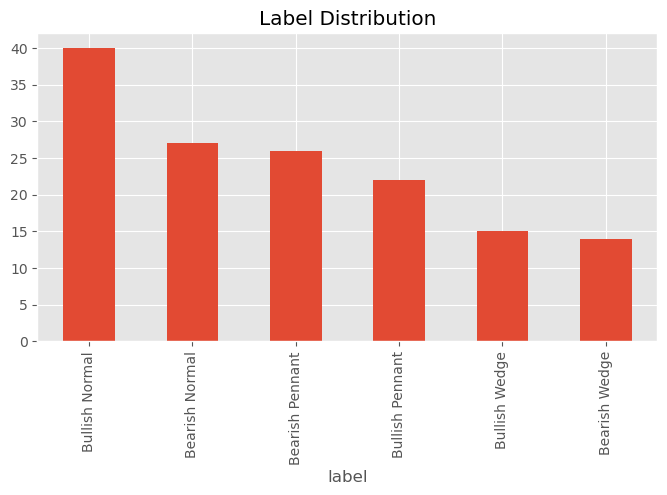

label
Bullish Normal     40
Bearish Normal     27
Bearish Pennant    26
Bullish Pennant    22
Bullish Wedge      15
Bearish Wedge      14
Name: count, dtype: int64

In [ ]:
df_meta["label"].value_counts().plot(kind="bar", figsize=(8,4))
plt.title("Label Distribution")
plt.show()

df_meta["label"].value_counts()


Min length: 5
Max length: 393
Mean length: 34.38194444444444
Median length: 24.5


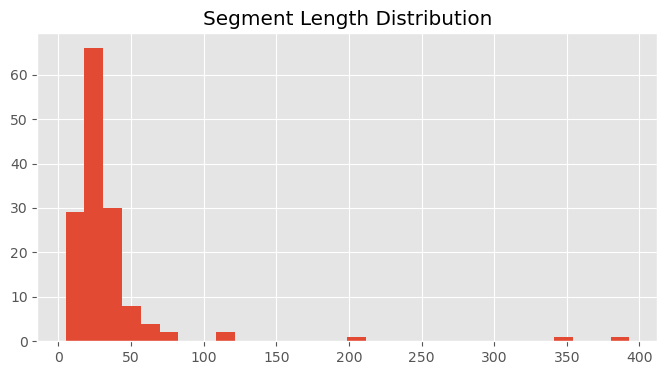

In [ ]:
lengths = df_meta["length"].values

print("Min length:", lengths.min())
print("Max length:", lengths.max())
print("Mean length:", lengths.mean())
print("Median length:", np.median(lengths))

plt.figure(figsize=(8,4))
plt.hist(lengths, bins=30)
plt.title("Segment Length Distribution")
plt.show()


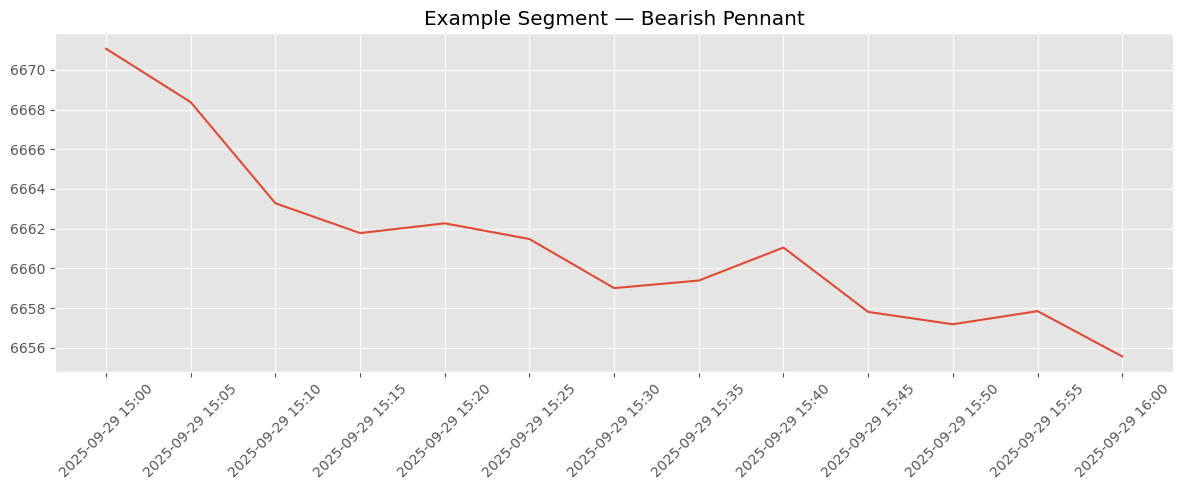

seg_df columns: Index(['timestamp', 'open', 'high', 'low', 'close'], dtype='object')
          timestamp         open         high          low        close
0  2025-09-29 15:00  6670.169922  6671.689941  6669.669922  6671.060059
1  2025-09-29 15:05  6671.100098  6671.370117  6668.310059  6668.370117
2  2025-09-29 15:10  6668.450195  6668.529785  6663.020020  6663.279785
3  2025-09-29 15:15  6663.169922  6663.169922  6658.319824  6661.779785
4  2025-09-29 15:20  6661.759766  6665.299805  6659.799805  6662.270020


In [ ]:
sample = all_segments[0]
seg_df = sample["segment_data"]

plt.figure(figsize=(12,5))
plt.plot(seg_df["timestamp"], seg_df["close"], label="Close Price")
plt.title(f"Example Segment — {sample['label']}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("seg_df columns:", seg_df.columns)
print(seg_df.head())

In [ ]:
dataset = []

for seg in all_segments:
    dataset.append({
        "label": seg["label"],
        "csv_file": seg["csv_file"],
        "data": seg["segment_data"]
    })

len(dataset)


144

In [ ]:
print("Total labeled segments:", len(dataset))
print("Unique labels:", df_meta["label"].unique())
df_meta.describe()


Total labeled segments: 144
Unique labels: ['Bearish Pennant' 'Bearish Wedge' 'Bullish Pennant' 'Bullish Wedge'
 'Bullish Normal' 'Bearish Normal']


,length
count,144.000000
mean,34.381944
std,46.002888
min,5.000000
25%,18.000000
50%,24.500000
75%,35.250000
max,393.000000


In [ ]:
# Persist loaded data to the workspace data directory
import os
import pickle
import h5py
import numpy as np

EXPORT_DIR = os.path.join(BASE_DATA_DIR, "export")
os.makedirs(EXPORT_DIR, exist_ok=True)
print("Exporting data to:", EXPORT_DIR)

# 1) Save metadata summary
meta_csv_path = os.path.join(EXPORT_DIR, "segments_meta.csv")
df_meta.to_csv(meta_csv_path, index=False)
print("Saved metadata CSV:", meta_csv_path)

# 2) Save full segments to HDF5 (efficient, reloadable)
h5_path = os.path.join(EXPORT_DIR, "segments.h5")
with h5py.File(h5_path, "w") as h5:
    grp = h5.create_group("segments")
    for i, seg in enumerate(all_segments):
        sgrp = grp.create_group(str(i))
        # Store attributes
        sgrp.attrs["label"] = seg["label"]
        sgrp.attrs["csv_file"] = seg["csv_file"]
        sgrp.attrs["start"] = seg["start"]
        sgrp.attrs["end"] = seg["end"]
        sgrp.attrs["length"] = seg["length"]
        # Store the segment dataframe with numeric values only
        seg_df = seg["segment_data"].copy()
        cols = seg_df.columns.tolist()
        # If timestamp exists, replace it with a sequential integer index
        if "timestamp" in seg_df.columns:
            seq_index = np.arange(len(seg_df), dtype=np.int64)
            sgrp.create_dataset("seq_index", data=seq_index)
            seg_df = seg_df.drop(columns=["timestamp"])  # drop original timestamp
            cols = seg_df.columns.tolist()
        sgrp.create_dataset("columns", data=[c.encode("utf-8") for c in cols])
        # Convert remaining columns to numeric and save as float64
        num_df = seg_df.apply(pd.to_numeric, errors="coerce")
        values = num_df.to_numpy(dtype=np.float64)
        sgrp.create_dataset("values", data=values)
print("Saved HDF5 segments:", h5_path)

# 3) Save a simple pickle backup (list of dicts)
pkl_path = os.path.join(EXPORT_DIR, "dataset.pkl")
with open(pkl_path, "wb") as f:
    pickle.dump({"df_meta": df_meta, "all_segments": all_segments}, f)
print("Saved pickle dataset:", pkl_path)

# 4) Save combined CSV with same content as HDF5
#    Schema: segment_id, label, csv_file, seq_index (0..N-1), and numeric columns
combined_csv_path = os.path.join(EXPORT_DIR, "segments_values.csv")
import pandas as pd
rows = []
for i, seg in enumerate(all_segments):
    seg_df = seg["segment_data"].copy()
    # Build sequential index regardless of timestamp presence
    seq_index = np.arange(len(seg_df), dtype=np.int64)
    # Drop timestamp if present
    if "timestamp" in seg_df.columns:
        seg_df = seg_df.drop(columns=["timestamp"])  # numeric columns remain
    # Coerce to numeric
    seg_df = seg_df.apply(pd.to_numeric, errors="coerce")
    # Attach metadata and seq index
    seg_df.insert(0, "seq_index", seq_index)
    seg_df.insert(0, "csv_file", seg["csv_file"])
    seg_df.insert(0, "label", seg["label"])
    seg_df.insert(0, "segment_id", i)
    rows.append(seg_df)
if rows:
    combined_df = pd.concat(rows, axis=0, ignore_index=True)
    # Ensure rows belonging to the same segment are contiguous and ordered
    combined_df = combined_df.sort_values(["segment_id", "seq_index"], kind="mergesort").reset_index(drop=True)
    combined_df.to_csv(combined_csv_path, index=False)
    print("Saved combined segments CSV:", combined_csv_path)
else:
    print("No segments to export to CSV.")

Exporting data to: /work/data/export
Saved metadata CSV: /work/data/export/segments_meta.csv
Saved HDF5 segments: /work/data/export/segments.h5
Saved pickle dataset: /work/data/export/dataset.pkl
Saved combined segments CSV: /work/data/export/segments_values.csv
Saved HDF5 segments: /work/data/export/segments.h5
Saved pickle dataset: /work/data/export/dataset.pkl
Saved combined segments CSV: /work/data/export/segments_values.csv


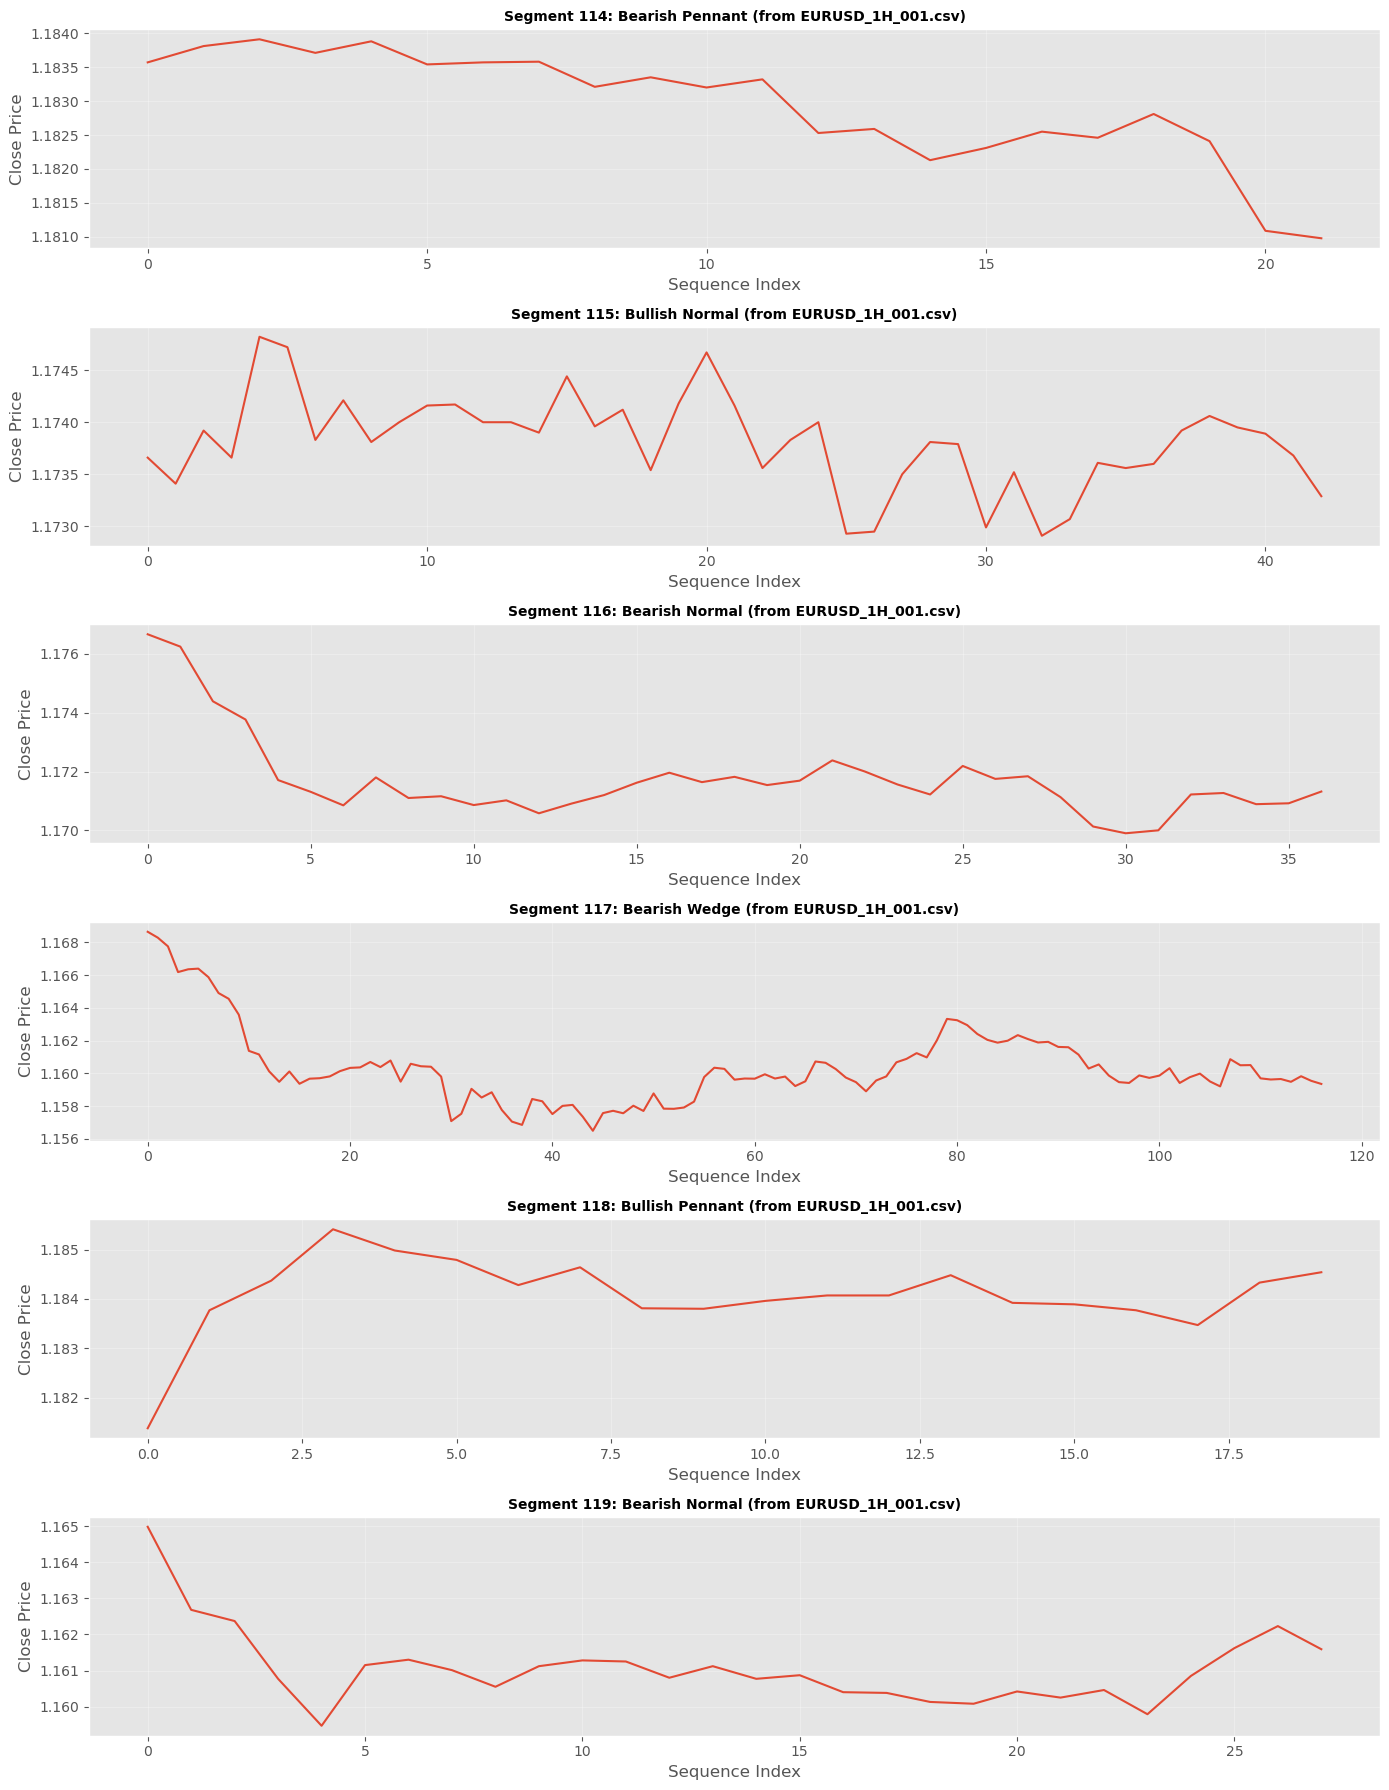

Displayed 6 segments out of 30 total segments


In [ ]:
# Visualize a sample of segments from combined_df
import matplotlib.pyplot as plt

# Get unique segment IDs
unique_segments = combined_df['segment_id'].unique()[-30:]

# Plot first 6 segments (or fewer if less available)
n_plots = min(6, len(unique_segments))
fig, axes = plt.subplots(n_plots, 1, figsize=(14, 3*n_plots))

if n_plots == 1:
    axes = [axes]

for idx, seg_id in enumerate(unique_segments[:n_plots]):
    seg_data = combined_df[combined_df['segment_id'] == seg_id]
    label = seg_data['label'].iloc[0]
    csv_file = seg_data['csv_file'].iloc[0]
    
    # Plot the Close price
    axes[idx].plot(seg_data['seq_index'], seg_data['close'], linewidth=1.5)
    axes[idx].set_title(f"Segment {seg_id}: {label} (from {csv_file})", fontsize=10, fontweight='bold')
    axes[idx].set_xlabel("Sequence Index")
    axes[idx].set_ylabel("Close Price")
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Displayed {n_plots} segments out of {len(unique_segments)} total segments")

In [ ]:
# Diagnostic: summarize extracted segments per CSV file
from collections import Counter

if not all_segments:
    print("[diag] No segments extracted yet. Run the earlier cells first.")
else:
    seg_counts = Counter()
    label_counts = {}  # csv_file -> Counter of labels
    for seg in all_segments:
        csv_file = seg["csv_file"]
        label = seg["label"]
        seg_counts[csv_file] += 1
        label_counter = label_counts.setdefault(csv_file, Counter())
        label_counter[label] += 1

    rows = []
    for csv_file, count in seg_counts.items():
        row = {
            "csv_file": csv_file,
            "segment_count": count,
        }
        # Expand label distribution into separate columns for quick inspection
        for label, c in label_counts[csv_file].items():
            col_name = f"label_{label}"
            row[col_name] = c
        rows.append(row)

    seg_summary_df = pd.DataFrame(rows)
    seg_summary_df = seg_summary_df.sort_values("segment_count", ascending=False).reset_index(drop=True)

    print("[diag] Segment counts per CSV file:")
    display(seg_summary_df)

[diag] Segment counts per CSV file:


,csv_file,segment_count,label_Bearish Pennant,label_Bearish Wedge,label_Bullish Pennant,label_Bullish Wedge,label_Bullish Normal,label_Bearish Normal
0,EURUSD_1H_001.csv,54,6.0,5.0,11.0,3.0,17.0,12.0
1,XAUUSD_15min.csv,14,2.0,3.0,NaN,3.0,3.0,3.0
2,XAUUSD_5min.csv,10,1.0,NaN,2.0,NaN,4.0,3.0
3,XAUUSD_30min.csv,8,2.0,NaN,NaN,NaN,2.0,4.0
4,EURUSDX_2025-10-25_to_2025-10-29_5m.csv,7,3.0,NaN,1.0,1.0,2.0,NaN
5,EURUSDX_2025-09-05_to_2025-09-09_5m.csv,4,1.0,NaN,NaN,2.0,1.0,NaN
6,EURUSDX_2025-09-10_to_2025-09-14_5m.csv,4,NaN,NaN,NaN,1.0,2.0,1.0
7,EURUSDX_2025-09-15_to_2025-09-19_5m.csv,4,1.0,1.0,NaN,NaN,2.0,NaN
8,EURUSDX_2025-10-10_to_2025-10-14_5m.csv,4,1.0,1.0,1.0,1.0,NaN,NaN
9,GSPC_2025-09-25_to_2025-09-29_5m.csv,3,1.0,1.0,1.0,NaN,NaN,NaN
